In [146]:
import torch as torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from DataRead import OurData
import traceback
import struct

from kan import KAN, create_dataset

torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 28*28 # from 28*28

In [147]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, dtype, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for _ in range(dims))
        return torch.tensor(np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)).to(torch.float32)

class OurData:
    def __init__(self):
        self.ourdataset = {}
        train_images = read_idx('/workspaces/KAN-Network/Dataset/train-images-idx3-ubyte/train-images-idx3-ubyte') #contains the training data, each data is the binary representation of an image as per the MNIST dataset
        self.ourdataset['train_input'] = (train_images).view(-1, 28*28) #reshapes the data into a 2D array, each row is an image
        test_images = read_idx('/workspaces/KAN-Network/Dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte') #contains the testing data, same format as train_input
        self.ourdataset['test_input'] = (test_images).view(-1, 28*28) #reshapes the data into a 2D array, each row is an image
        self.ourdataset['train_label'] = read_idx('/workspaces/KAN-Network/Dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte').unsqueeze(1) #contains the labels for the training data
        self.ourdataset['test_label'] = read_idx('/workspaces/KAN-Network/Dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte').unsqueeze(1) #contains the labels for the testing data
        #print("These are our training inputs and labels")
    def __getitem__(self):
        return self.ourdataset
    def getitems(self, index, endindex = 10000, test = True):
        key = 'test_input' if test else 'train_input'
        key2 = 'test_label' if test else 'train_label'
        return [self.ourdataset[key][index:endindex], self.ourdataset[key2][index:endindex]]

In [148]:
def getsliced(dataset, slice = 1):
        fraction = int(784/slice)
        arr = torch.tensor([])
        for i in range(slice):
            arr = torch.cat((arr, dataset[:, i*fraction:(i+1)*fraction].sum(dim=1, keepdim=True)), dim=1)
        return arr

data = OurData() #Our dataset
ourdata = {}
ourdata2 = {}
ourdata3 = {}
for key in data.ourdataset:
    #total train datapoints=60000, test datapoints=10000. approx time:
    ourdata[key] = data.ourdataset[key][:100] #only get the first 100 data points for now
    ourdata2[key] = getsliced(data.ourdataset[key], 28)[:1000] #each element is a sum of a row of the 2d array
    ourdata3[key] = getsliced(data.ourdataset[key], 3)[:2000] #each element is a sum of a third of the entire 2d array

In [149]:
'''
initialize model
- refer to MultKAN.py for more information
    width: number of neurons in each layer, in order from input to output
    k: order of the spline
    seed: random seed
    grid: grid intervals/grid points (affects the accuracy of the splines/learnable functions)
'''
model = KAN(width=[784, 10, 1], grid=5, k=3, seed=0, device=device)
model2 = KAN(width=[28, 10, 1], grid=5, k=3, seed=0, device=device, ckpt_path='./model2')
model3 = KAN(width=[3, 5, 1], grid=5, k=3, seed=0, device=device, ckpt_path='./model3')

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model2
saving model version 0.0
checkpoint directory created: ./model3
saving model version 0.0


In [150]:
model(ourdata['train_input']) #forward pass of the model
model2(ourdata2['train_input']) 
model3(ourdata3['train_input']) 
#print("model pass complete")
#model.plot() #plots the model, avoid doing this since it will plot functions for all the neurons(and we have a lot since we are dealing with images)

modelresults = []
modelresults.append(model.fit(ourdata, opt="LBFGS", steps=50, lamb=0.001)) #values from the basic example in the documentation
modelresults.append(model2.fit(ourdata2, opt="LBFGS", steps=50, lamb=0.001))
modelresults.append(model3.fit(ourdata3, opt="LBFGS", steps=50, lamb=0.001))

| train_loss: 7.52e-03 | test_loss: 2.10e+00 | reg: 2.98e+01 | : 100%|█| 50/50 [01:06<00:00,  1.33s/


saving model version 0.1


| train_loss: 9.87e-01 | test_loss: 9.64e-01 | reg: 2.43e+01 | : 100%|█| 50/50 [00:20<00:00,  2.44it


saving model version 0.1


| train_loss: 2.66e+00 | test_loss: 2.62e+00 | reg: 1.47e+01 | : 100%|█| 50/50 [00:07<00:00,  6.45it

saving model version 0.1


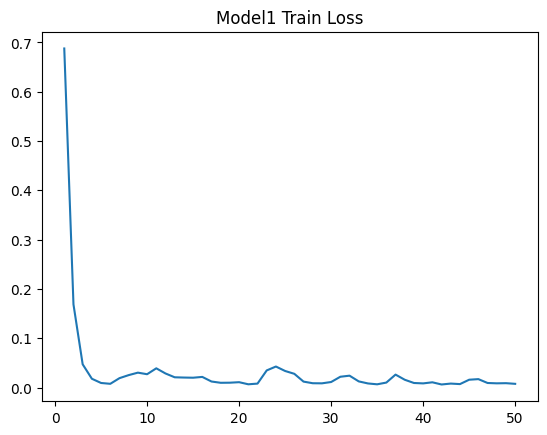

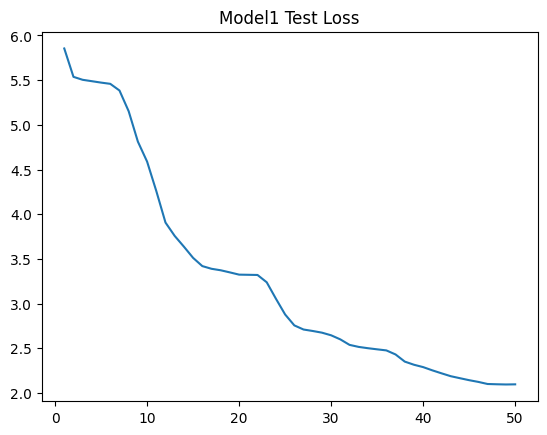

In [151]:
plt.plot(range(1, len(modelresults[0]['train_loss']) + 1), modelresults[0]['train_loss'])
plt.title('Model1 Train Loss')
plt.show()
plt.plot(range(1, len(modelresults[0]['test_loss']) + 1), modelresults[0]['test_loss'])
plt.title('Model1 Test Loss')
plt.show()

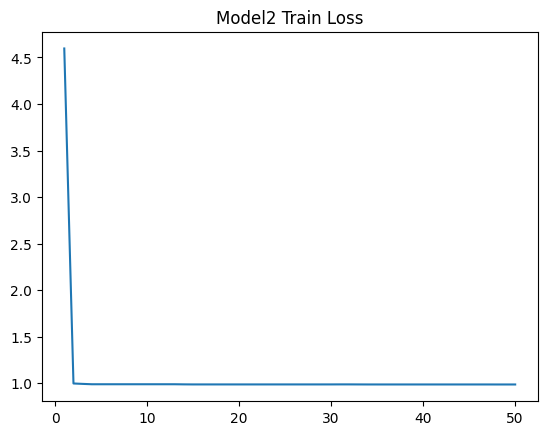

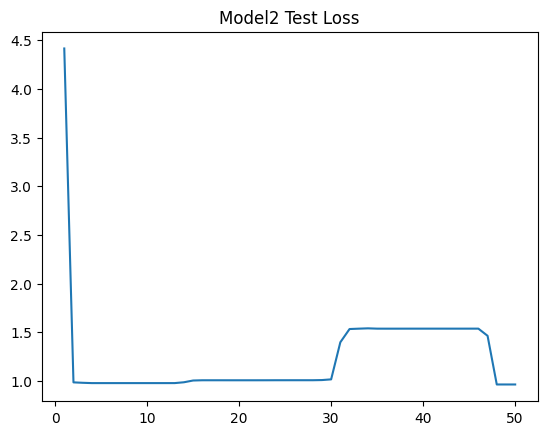

In [152]:
plt.plot(range(1, len(modelresults[1]['train_loss']) + 1), modelresults[1]['train_loss'])
plt.title('Model2 Train Loss')
plt.show()
plt.plot(range(1, len(modelresults[1]['test_loss']) + 1), modelresults[1]['test_loss'])
plt.title('Model2 Test Loss')
plt.show()

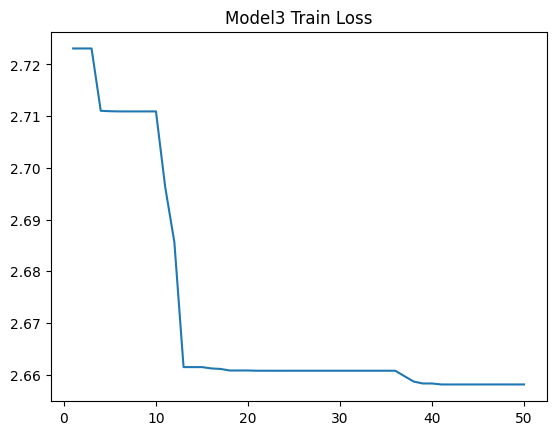

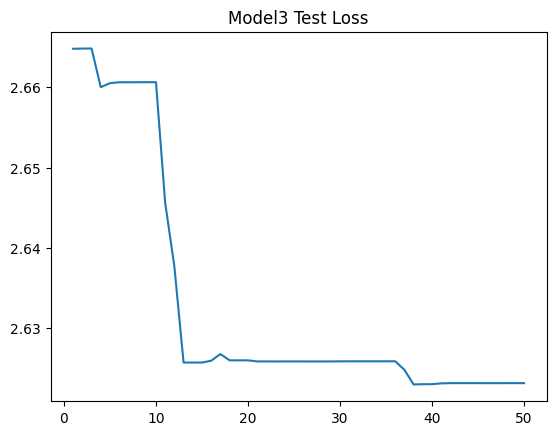

In [153]:
plt.plot(range(1, len(modelresults[2]['train_loss']) + 1), modelresults[2]['train_loss'])
plt.title('Model3 Train Loss')
plt.show()
plt.plot(range(1, len(modelresults[2]['test_loss']) + 1), modelresults[2]['test_loss'])
plt.title('Model3 Test Loss')
plt.show()

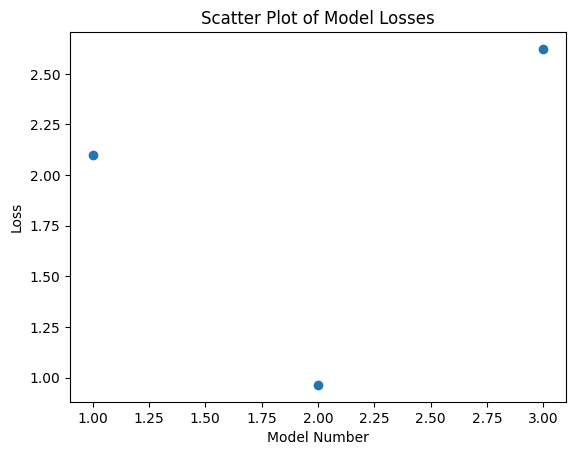

In [154]:
# Assuming model.evaluate returns a dictionary with 'predictions' and 'targets'
eval1 = model.evaluate(ourdata)
eval2 = model2.evaluate(ourdata2)
eval3 = model3.evaluate(ourdata3)
evaluation_results = [eval1, eval2, eval3]
test_losses = [[result['test_loss'] for result in evaluation_results]]

plt.scatter([i for i in range(1, 4)], test_losses)
plt.xlabel('Model Number')
plt.ylabel('Loss')
plt.title('Scatter Plot of Model Losses')
plt.show()

In [155]:
testingdata = data.getitems(9950, 10000) 
results = model.forward(testingdata[0])
results2 = model2.forward(getsliced(testingdata[0], 28))
results3 = model3.forward(getsliced(testingdata[0], 3))

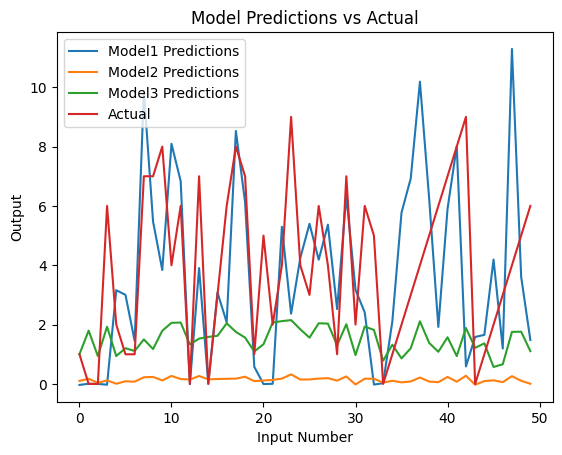

In [157]:
plt.plot(range(len(results)), results.detach().numpy(), label='Model1 Predictions')
plt.plot(range(len(results2)), results2.detach().numpy(), label='Model2 Predictions')
plt.plot(range(len(results3)), results3.detach().numpy(), label='Model3 Predictions')
plt.plot(range(len(testingdata[1])), testingdata[1].detach().numpy(), label='Actual')
plt.xlabel('Input Number')
plt.ylabel('Output')
plt.title('Model Predictions vs Actual')
plt.legend()
plt.show()